In [131]:
import numpy as np
from numpy import pi, cos, sin, sqrt


def flat_ground(x, y):
    return 0


def trajectory_3d(
    theta, phi, speed=20, height=0, dt=0.01, g=-9.81, elevation=flat_ground
):  # 横向角度ϕ是模拟器的输入参数
    vx = speed * cos(pi * theta / 180) * cos(pi * phi / 180)
    vy = speed * cos(pi * theta / 180) * sin(pi * phi / 180)  # 计算初始y速度
    vz = speed * sin(pi * theta / 180)
    t, x, y, z = 0, 0, 0, height
    ts, xs, ys, zs = [t], [x], [y], [z]  # 存储在整个模拟过程中的时间值以及x、y和z的位置
    while z >= elevation(x, y):
        t += dt
        vz += g * dt
        x += vx * dt
        y += vy * dt  # 在每次迭代中更新y的位置
        z += vz * dt
        ts.append(t)
        xs.append(x)
        ys.append(y)
        zs.append(z)
    return ts, xs, ys, zs

In [132]:
import matplotlib.pyplot as plt


# 适配中文字符
plt.rcParams["font.sans-serif"] = ["SimHei"]
plt.rcParams["axes.unicode_minus"] = False


def plot_trajectory_3d(
    directions, speed=20, height=0, dt=0.01, g=-9.81, figsize=(10, 8), elevation=flat_ground
):
    """
    绘制3D空间中炮弹的轨迹

    参数:
    directions: 发射方向的列表，每个方向是(theta, phi)的元组
                theta是仰角，phi是与x轴正方向的偏转角度
    speed: 发射速度
    height: 初始高度
    dt: 时间步长
    g: 重力加速度
    figsize: 图形大小
    """
    # 创建3D图形
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, projection="3d")

    # 记录坐标范围以便调整视图
    min_x, max_x = 0, 0
    min_y, max_y = 0, 0
    min_z, max_z = 0, 0

    # 为不同的轨迹使用不同的颜色
    colors = plt.cm.jet(np.linspace(0, 1, len(directions)))

    # 绘制每个方向的轨迹
    for i, (theta, phi) in enumerate(directions):
        print(
            f"----- 当前炮弹的发射角度为：theta={theta}°, phi={phi}°, 发射速度为：{speed} m/s, 发射高度为：{height} m -----"
        )
        ts, xs, ys, zs = trajectory_3d(theta, phi, speed, height, dt, g, elevation)

        # 更新坐标范围
        min_x = min(min_x, min(xs))
        max_x = max(max_x, max(xs))
        min_y = min(min_y, min(ys))
        max_y = max(max_y, max(ys))
        min_z = min(min_z, min(zs))
        max_z = max(max_z, max(zs))

        # 获取落点坐标
        print(
            f"炮弹在角度 theta={theta}°, phi={phi}° 时的落点坐标为：({xs[-1]:.2f}, {ys[-1]:.2f}, {zs[-1]:.2f})"
        )
        # 获取落地点在xy平面距离发射点的距离
        print(
            f"炮弹在角度 theta={theta}°, phi={phi}° 时的落地点在xy平面距离发射点的距离为：{sqrt(xs[-1]**2 + ys[-1]**2)}"
        )

        # 获取炮弹的置空时间和最大高度
        print(f"炮弹在角度 theta={theta}°, phi={phi}° 时的置空时间为：{ts[-1]:.2f}")
        print(f"炮弹在角度 theta={theta}°, phi={phi}° 时的最大高度为：{max(zs):.2f}")

        # 绘制轨迹
        ax.plot(xs, ys, zs, color=colors[i], label=f"θ={theta}°, φ={phi}°")

        # 标记发射点和落点
        ax.scatter([0], [0], [height], color="black", s=50, marker="o")
        ax.scatter([xs[-1]], [ys[-1]], [zs[-1]], color=colors[i], s=50, marker="x")

        print()

    # 设置轴标签和标题
    ax.set_xlabel("X (m)")
    ax.set_ylabel("Y (m)")
    ax.set_zlabel("Z (m)")
    ax.set_title(f"3D Projectile Motion with Initial Speed {speed} m/s")

    # 设置轴范围，确保x、y、z轴的比例相同
    # 计算每个维度的范围
    x_range = max_x - min_x
    y_range = max_y - min_y
    z_range = max_z - min_z
    
    # 确定最大范围，以保持相同比例
    max_range = max(x_range, y_range, z_range) * 1.5
    
    # 计算各轴的中点
    x_mid = (max_x + min_x) / 2
    y_mid = (max_y + min_y) / 2
    z_mid = (max_z + min_z) / 2
    
    # 设置等比例的坐标轴限制
    ax.set_xlim([x_mid - max_range/2, x_mid + max_range/2])
    ax.set_ylim([y_mid - max_range/2, y_mid + max_range/2])
    
    # 确保z轴的底部有适当的边距，而不是直接从0开始
    z_min = min(0, min_z)  # z轴的最小值应该是0或实际最小值中较小的那个
    z_margin = max_range * 0.1  # 添加10%的边距
    ax.set_zlim([z_min - z_margin, z_mid + max_range/2])
    
    # Create a proper grid for the elevation function that matches the axis limits
    x_grid = np.linspace(ax.get_xlim()[0], ax.get_xlim()[1], 100)
    y_grid = np.linspace(ax.get_ylim()[0], ax.get_ylim()[1], 100)
    X, Y = np.meshgrid(x_grid, y_grid)
    
    # Apply the elevation function to get the Z values
    Z = np.zeros_like(X)
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            Z[i, j] = elevation(X[i, j], Y[i, j])
    
    # Plot the surface representing the elevation
    ax.plot_surface(X, Y, Z, alpha=0.3, color="yellow", rstride=5, cstride=5)

    # 在z=0处添加网格平面以增强3D效果
    xx, yy = np.meshgrid(
        np.linspace(ax.get_xlim()[0], ax.get_xlim()[1], 10),
        np.linspace(ax.get_ylim()[0], ax.get_ylim()[1], 10),
    )
    zz = np.zeros_like(xx)
    ax.plot_surface(xx, yy, zz, alpha=0.2, color="gray")

    # 添加图例
    ax.legend(loc="upper right")

    # 调整视角以便更好地观察
    ax.view_init(elev=20, azim=-35)

    plt.grid(True)
    plt.tight_layout()
    plt.show()


----- 当前炮弹的发射角度为：theta=45°, phi=45°, 发射速度为：20 m/s, 发射高度为：0 m -----
炮弹在角度 theta=45°, phi=45° 时的落点坐标为：(28.80, 28.80, -0.10)
炮弹在角度 theta=45°, phi=45° 时的落地点在xy平面距离发射点的距离为：40.72935059634534
炮弹在角度 theta=45°, phi=45° 时的置空时间为：2.88
炮弹在角度 theta=45°, phi=45° 时的最大高度为：10.12

----- 当前炮弹的发射角度为：theta=30°, phi=60°, 发射速度为：20 m/s, 发射高度为：0 m -----
炮弹在角度 theta=30°, phi=60° 时的落点坐标为：(17.58, 30.45, -0.01)
炮弹在角度 theta=30°, phi=60° 时的落地点在xy平面距离发射点的距离为：35.160631393648096
炮弹在角度 theta=30°, phi=60° 时的置空时间为：2.03
炮弹在角度 theta=30°, phi=60° 时的最大高度为：5.05

----- 当前炮弹的发射角度为：theta=60°, phi=30°, 发射速度为：20 m/s, 发射高度为：0 m -----
炮弹在角度 theta=60°, phi=30° 时的落点坐标为：(30.57, 17.65, -0.15)
炮弹在角度 theta=60°, phi=30° 时的落地点在xy平面距离发射点的距离为：35.29999999999997
炮弹在角度 theta=60°, phi=30° 时的置空时间为：3.53
炮弹在角度 theta=60°, phi=30° 时的最大高度为：15.20



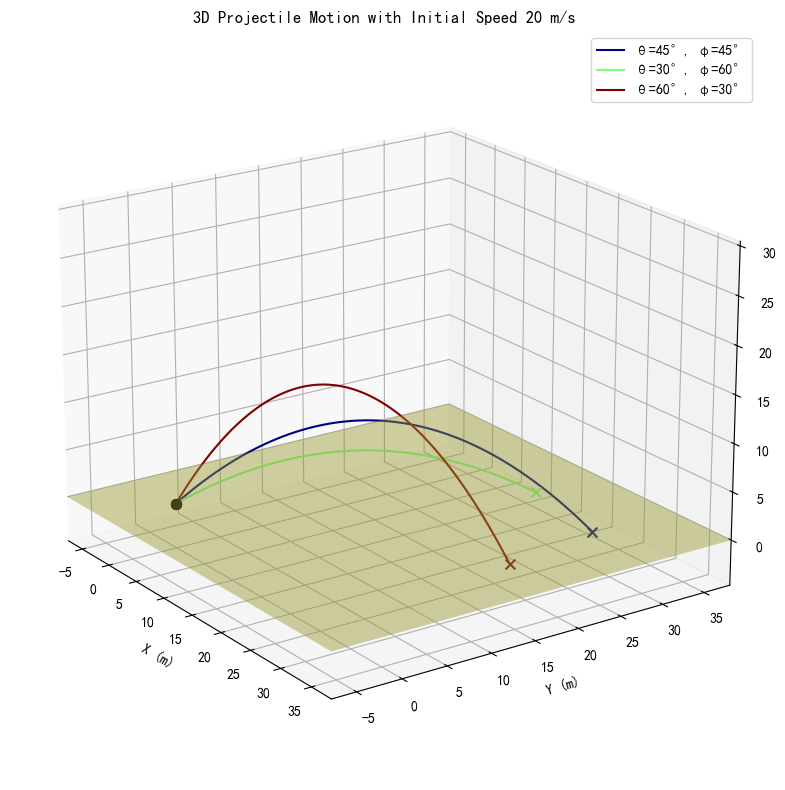

In [133]:
plot_trajectory_3d([(45, 45), (30, 60), (60, 30)])

In [134]:
def ridge(x, y):
    return (x**2 - 5 * (y**2)) / 2500

----- 当前炮弹的发射角度为：theta=20°, phi=0°, 发射速度为：20 m/s, 发射高度为：0 m -----
炮弹在角度 theta=20°, phi=0° 时的落点坐标为：(25.37, 0.00, 0.23)
炮弹在角度 theta=20°, phi=0° 时的落地点在xy平面距离发射点的距离为：25.371700761219596
炮弹在角度 theta=20°, phi=0° 时的置空时间为：1.35
炮弹在角度 theta=20°, phi=0° 时的最大高度为：2.35

----- 当前炮弹的发射角度为：theta=30°, phi=240°, 发射速度为：20 m/s, 发射高度为：0 m -----
炮弹在角度 theta=30°, phi=240° 时的落点坐标为：(-19.23, -33.30, -2.08)
炮弹在角度 theta=30°, phi=240° 时的落地点在xy平面距离发射点的距离为：38.45152792802894
炮弹在角度 theta=30°, phi=240° 时的置空时间为：2.22
炮弹在角度 theta=30°, phi=240° 时的最大高度为：5.05

----- 当前炮弹的发射角度为：theta=20°, phi=270°, 发射速度为：20 m/s, 发射高度为：0 m -----
炮弹在角度 theta=20°, phi=270° 时的落点坐标为：(-0.00, -30.45, -1.87)
炮弹在角度 theta=20°, phi=270° 时的落地点在xy平面距离发射点的距离为：30.446040913463523
炮弹在角度 theta=20°, phi=270° 时的置空时间为：1.62
炮弹在角度 theta=20°, phi=270° 时的最大高度为：2.35



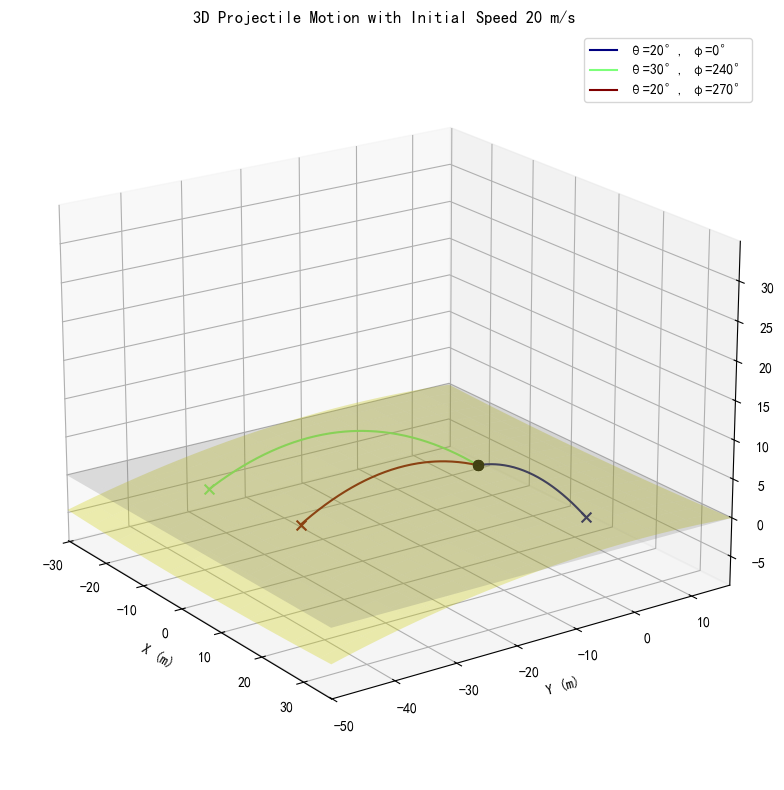

In [135]:
plot_trajectory_3d([(20, 0), (30, 240), (20, 270)], elevation=ridge)

In [136]:
B = 0.0004      # 山脊形状、发射速度和重力加速度常数
C = 0.002
v = 20
g = -9.81

def velocity_components(v,theta,phi):      # 一个辅助函数，用于求初始速度的x、y和z分量
    vx = v  * cos(theta*pi/180) * cos(phi*pi/180)
    vy = v  * cos(theta*pi/180) * sin(phi*pi/180)
    vz = v  * sin(theta*pi/180)
    return vx,vy,vz

def landing_distance(theta,phi):
    vx, vy, vz = velocity_components(v, theta, phi)
    v_xy = sqrt(vx**2 + vy**2)      # 初始速度的水平分量（平行于xy平面）
    a = (g/2) - B * (vx**2) + C * (vy**2)      # 常数a和b
    b = vz
    landing_time = -b/a      # 求解落地时间的二次方程，即−b/a
    landing_distance = v_xy * landing_time      # 水平距离
    return landing_distance

In [137]:
print(f'20,   0 的落地距离为：{landing_distance(20, 0)}')
print(f'30, 240 的落地距离为：{landing_distance(30, 240)}')
print(f'20, 270 的落地距离为：{landing_distance(20, 270)}')

20,   0 的落地距离为：25.475683346901437
30, 240 的落地距离为：38.618747102985
20, 270 的落地距离为：30.619269819379916


In [138]:
def plot_plane(elevation=flat_ground, x_range=(-10, 10), y_range=(-10, 10), z_range=(-10, 10)):
    """
    绘制一个平面的3D图形

    参数:
    elevation: 高程函数
    x_range: x轴范围
    y_range: y轴范围
    z_range: z轴范围
    """
    # 创建3D图形
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection="3d")

    # 创建网格
    x = np.linspace(*x_range, 100)
    y = np.linspace(*y_range, 100)
    X, Y = np.meshgrid(x, y)
    Z = elevation(X, Y)

    # 绘制3D图形
    surf = ax.plot_surface(X, Y, Z, cmap="viridis")

    # 设置轴标签和标题
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.set_title("3D Plane")
    
    # 设置z轴范围
    ax.set_zlim(z_range)
    
    # 添加颜色条
    fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)

    plt.tight_layout()
    plt.show()

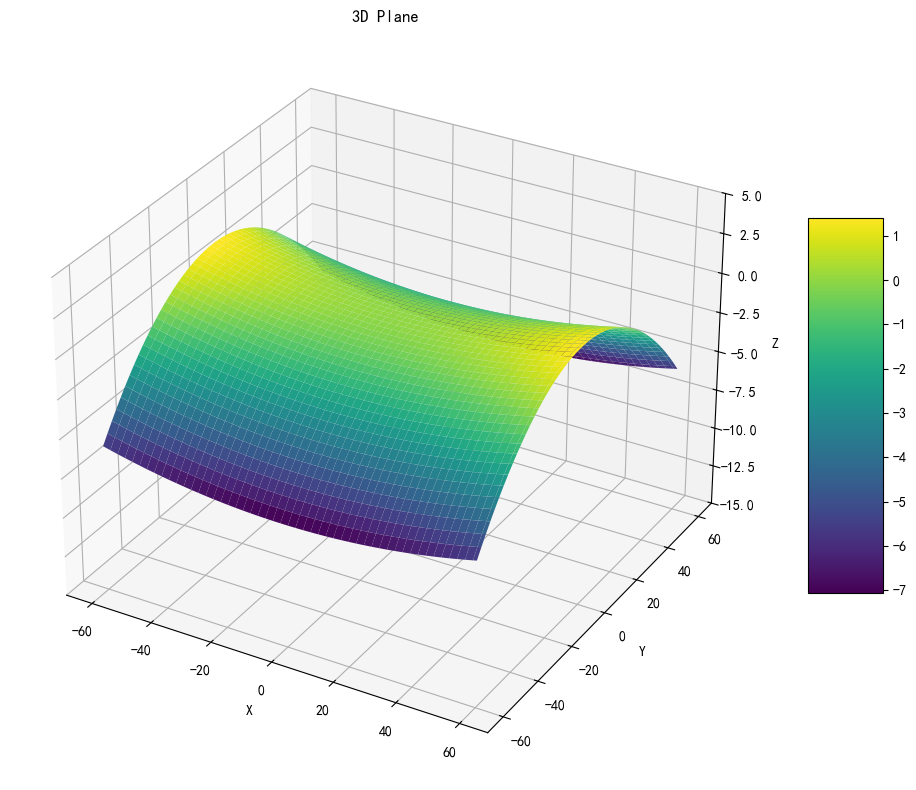

In [139]:
plot_plane(ridge, x_range=(-60, 60), y_range=(-60, 60), z_range=(-15, 5))

In [150]:
def plot_projection_distance_heat_map(
    speed=20,
    height=0,
    dt=0.01,
    g=-9.81,
    elevation=ridge,
    theta_range=(0, 90),
    phi_range=(0, 360),
    resolution=10,
    show_plot=True,  # 新参数，控制是否立即显示图形
    show_max_point=True,
):
    """
    绘制从(0,0)点发射的炮弹在不同角度(theta, phi)下的射程热图

    参数:
    speed: 炮弹初速度 (m/s)
    height: 发射高度 (m)
    dt: 时间步长
    g: 重力加速度 (m/s²)
    elevation: 地面高程函数
    theta_range: 仰角θ范围，元组(最小值, 最大值)，单位为度
    phi_range: 方位角φ范围，元组(最小值, 最大值)，单位为度
    resolution: 角度分辨率，每个维度的步数
    show_plot: 是否立即显示图形

    返回:
    fig: matplotlib图形对象
    ax: matplotlib坐标轴对象
    theta_values: 仰角θ值的数组
    phi_values: 方位角φ值的数组
    distances: 射程数据的二维数组
    """
    # 创建角度网格
    theta_values = np.linspace(theta_range[0], theta_range[1], resolution)
    phi_values = np.linspace(phi_range[0], phi_range[1], resolution)

    # 创建用于存储射程的二维数组
    distances = np.zeros((len(theta_values), len(phi_values)))

    # 计算每个角度组合的射程
    for i, theta in enumerate(theta_values):
        for j, phi in enumerate(phi_values):
            # 计算炮弹轨迹
            _, xs, ys, _ = trajectory_3d(theta, phi, speed, height, dt, g, elevation)
            # 计算水平射程（从发射点到落点的直线距离）
            distance = np.sqrt(xs[-1] ** 2 + ys[-1] ** 2)
            distances[i, j] = distance

    # 创建网格用于绘图
    Theta, Phi = np.meshgrid(theta_values, phi_values)

    # 创建图形和坐标轴
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111)

    # 绘制热图
    im = ax.pcolormesh(Theta, Phi, distances.T, cmap="jet", shading="auto")

    # 设置标签和标题
    ax.set_xlabel("仰角 θ (度)")
    ax.set_ylabel("方位角 φ (度)")
    ax.set_title("炮弹射程热图 - 仰角θ vs 方位角φ")

    # 添加颜色条
    cbar = fig.colorbar(im, ax=ax)
    cbar.set_label("射程 (m)")

    # 找出最大射程及其对应的角度
    max_distance = np.max(distances)
    max_idx = np.unravel_index(distances.argmax(), distances.shape)
    max_theta = theta_values[max_idx[0]]
    max_phi = phi_values[max_idx[1]]
    if show_max_point:

        # 在图上标记最大射程点
        ax.plot(max_theta, max_phi, "r*", markersize=15)
        ax.annotate(
            f"最大射程: {max_distance:.2f}m\nθ={max_theta:.1f}°, φ={max_phi:.1f}°",
            xy=(max_theta, max_phi),
            xytext=(max_theta + 5, max_phi + 20),
            arrowprops=dict(facecolor="black", shrink=0.05, width=1.5),
        )

    # 设置网格
    ax.grid(True)

    # 布局调整
    plt.tight_layout()

    # 打印最优角度和最大射程
    print(f"最大射程: {max_distance:.2f} m")
    print(f"最优仰角(θ): {max_theta:.2f}°")
    print(f"最优方位角(φ): {max_phi:.2f}°")

    # 如果需要，显示图形
    if show_plot:
        plt.show()

    return fig, ax, theta_values, phi_values, distances

最大射程: 44.52 m
最优仰角(θ): 42.73°
最优方位角(φ): 90.91°


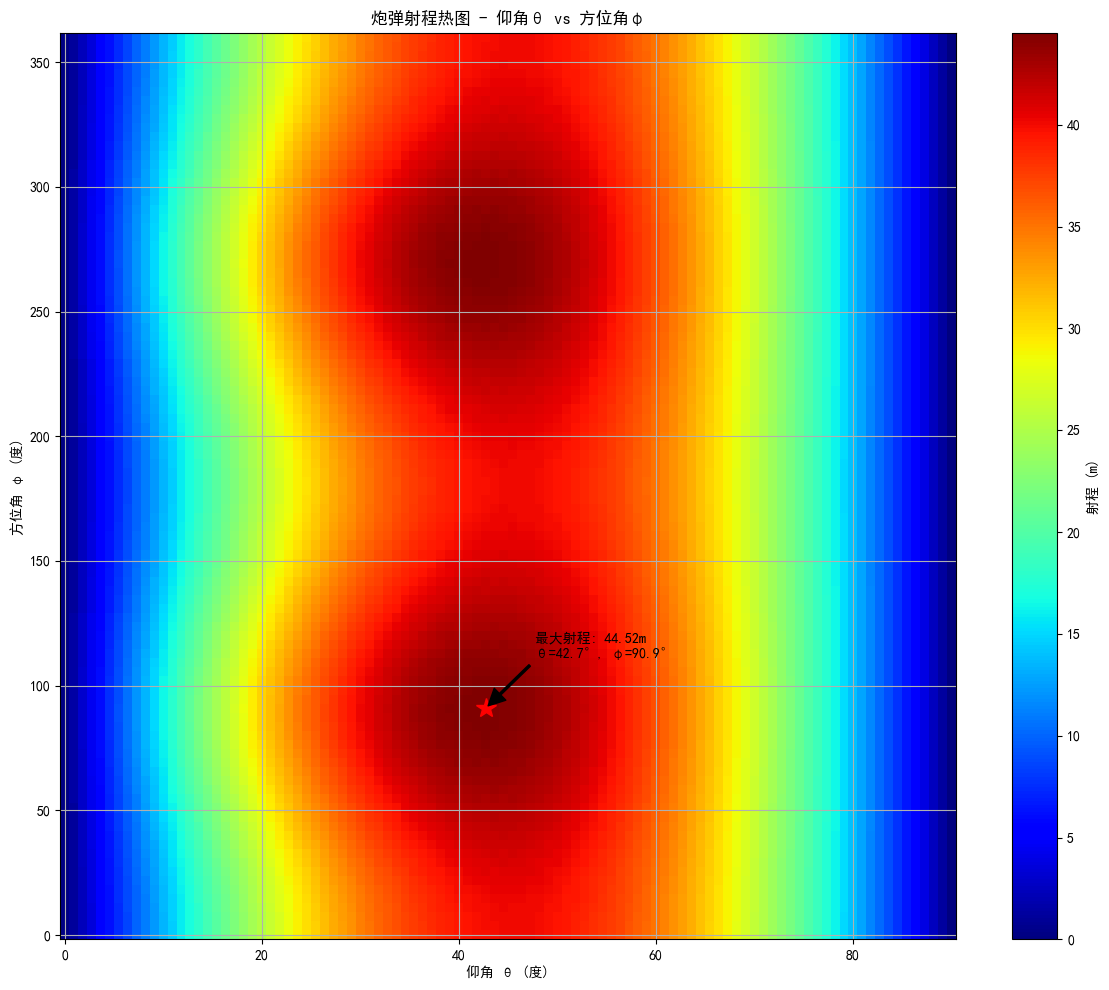

In [151]:
# 使用更高的分辨率绘制热图
fig, ax, theta_values, phi_values, distances = plot_projection_distance_heat_map(
    speed=20, resolution=100, elevation=ridge  # 增加分辨率以获得更平滑的热图
)

In [ ]:
# 求指定函数线段的斜率
def secant_slope(f, xmin, xmax):  # 求x值在xmin和xmax之间的割线f(x)的斜率
    return (f(xmax) - f(xmin)) / (xmax - xmin)


# 求指定函数在指定点的近似导数
def approx_derivative(f, x, dx=1e-6):  # 近似导数是x−10−6和x+10−6之间的一条割线
    return secant_slope(f, x - dx, x + dx)


# 求指定函数在指定点的梯度
def approx_gradient(f, x0, y0, dx=1e-6):
    partial_x = approx_derivative(lambda x: f(x, y0), x0, dx=dx)
    partial_y = approx_derivative(lambda y: f(x0, y), y0, dx=dx)
    return (partial_x, partial_y)


# 求指定函数在指定点的梯度
def landing_distance_gradient(theta, phi):
    return approx_gradient(landing_distance, theta, phi)

In [177]:
def plot_projection_distance_heat_map_with_gradient(
    speed=20,
    height=0,
    dt=0.01,
    g=-9.81,
    elevation=ridge,
    theta_range=(0, 90),
    phi_range=(0, 360),
    resolution=10,
    gradient_scale=5.0,  # 梯度箭头的缩放因子
    gradient_density=4,  # 每个维度上绘制梯度的数量
    show_plot=True,  # 是否立即显示图形
):
    """
    绘制从(0,0)点发射的炮弹在不同角度(theta, phi)下的射程热图，并添加梯度向量

    参数:
    speed: 炮弹初速度 (m/s)
    height: 发射高度 (m)
    dt: 时间步长
    g: 重力加速度 (m/s²)
    elevation: 地面高程函数
    theta_range: 仰角θ范围，元组(最小值, 最大值)，单位为度
    phi_range: 方位角φ范围，元组(最小值, 最大值)，单位为度
    resolution: 角度分辨率，每个维度的步数
    gradient_scale: 梯度箭头的缩放因子
    gradient_density: 每个维度上绘制梯度的数量
    show_plot: 是否立即显示图形
    """
    # 首先获取基础热图
    fig, ax, theta_values, phi_values, distances = plot_projection_distance_heat_map(
        speed=speed,
        height=height,
        dt=dt,
        g=g,
        elevation=elevation,
        theta_range=theta_range,
        phi_range=phi_range,
        resolution=resolution,
        show_plot=False,  # 不立即显示
        show_max_point=False,  # 不显示最大点
    )

    # 为梯度箭头创建采样点网格
    # 使用比热图分辨率更低的密度来避免箭头过密
    theta_samples = np.linspace(theta_range[0], theta_range[1], gradient_density)
    phi_samples = np.linspace(phi_range[0], phi_range[1], gradient_density)

    # 固定箭头头部参数
    head_width = 2.5
    head_length = 1.0
    arrow_width = 0.5

    # 计算当前轴的宽高比
    width, height = fig.get_size_inches()
    aspect_ratio = width / height

    # 考虑到 phi 和 theta 的范围可能不同，计算比例因子
    theta_range_size = theta_range[1] - theta_range[0]
    phi_range_size = phi_range[1] - phi_range[0]
    scale_factor = (phi_range_size / theta_range_size) * aspect_ratio

    # 导入Matplotlib的补丁和路径模块，用于自定义箭头
    from matplotlib.patches import FancyArrow
    
    # 绘制梯度箭头
    for theta in theta_samples:
        for phi in phi_samples:
            # 计算梯度
            grad_theta, grad_phi = landing_distance_gradient(theta, phi)

            # 梯度缩放和方向调整
            # 注意：梯度方向是上升最快的方向，所以需要取正值
            arrow_dx = grad_theta * gradient_scale
            arrow_dy = grad_phi * gradient_scale

            # 调整箭头长度，避免非常小的梯度产生看不见的箭头
            arrow_length = sqrt(arrow_dx**2 + arrow_dy**2)
            min_length = 1.0  # 最小箭头长度

            if arrow_length < min_length:
                if arrow_length > 0:  # 避免除以零
                    scale_factor = min_length / arrow_length
                    arrow_dx *= scale_factor
                    arrow_dy *= scale_factor
                else:
                    # 如果梯度为零，画一个很小的圆点
                    import matplotlib.patches as mpatches

                    circle = mpatches.Circle((theta, phi), 0.5, color="black", alpha=0.7)
                    ax.add_patch(circle)
                    continue

            # 创建箭头
            arrow = FancyArrow(
                theta,
                phi,  # 起点
                arrow_dx,
                arrow_dy,  # 方向和长度
                width=arrow_width,
                head_width=head_width,
                head_length=head_length,
                length_includes_head=False,
                fc="black",  # 填充颜色
                ec="black",  # 轮廓颜色
                alpha=1,  # 透明度
                linewidth=0.5,
            )
            ax.add_patch(arrow)

    # 添加图例说明梯度箭头的含义
    # 创建一个示例箭头用于图例
    example_arrow = FancyArrow(
        0, 0, 5, 0,
        width=arrow_width,
        head_width=head_width,
        head_length=head_length,
        length_includes_head=True,
        fc='white',
        ec='black',
        alpha=0.7
    )

    # 更新标题，表明图中包含梯度信息
    ax.set_title("炮弹射程热图 - 仰角θ vs 方位角φ (带梯度方向)")

    if show_plot:
        plt.show()

    return fig, ax, theta_values, phi_values, distances

最大射程: 44.52 m
最优仰角(θ): 42.73°
最优方位角(φ): 90.91°


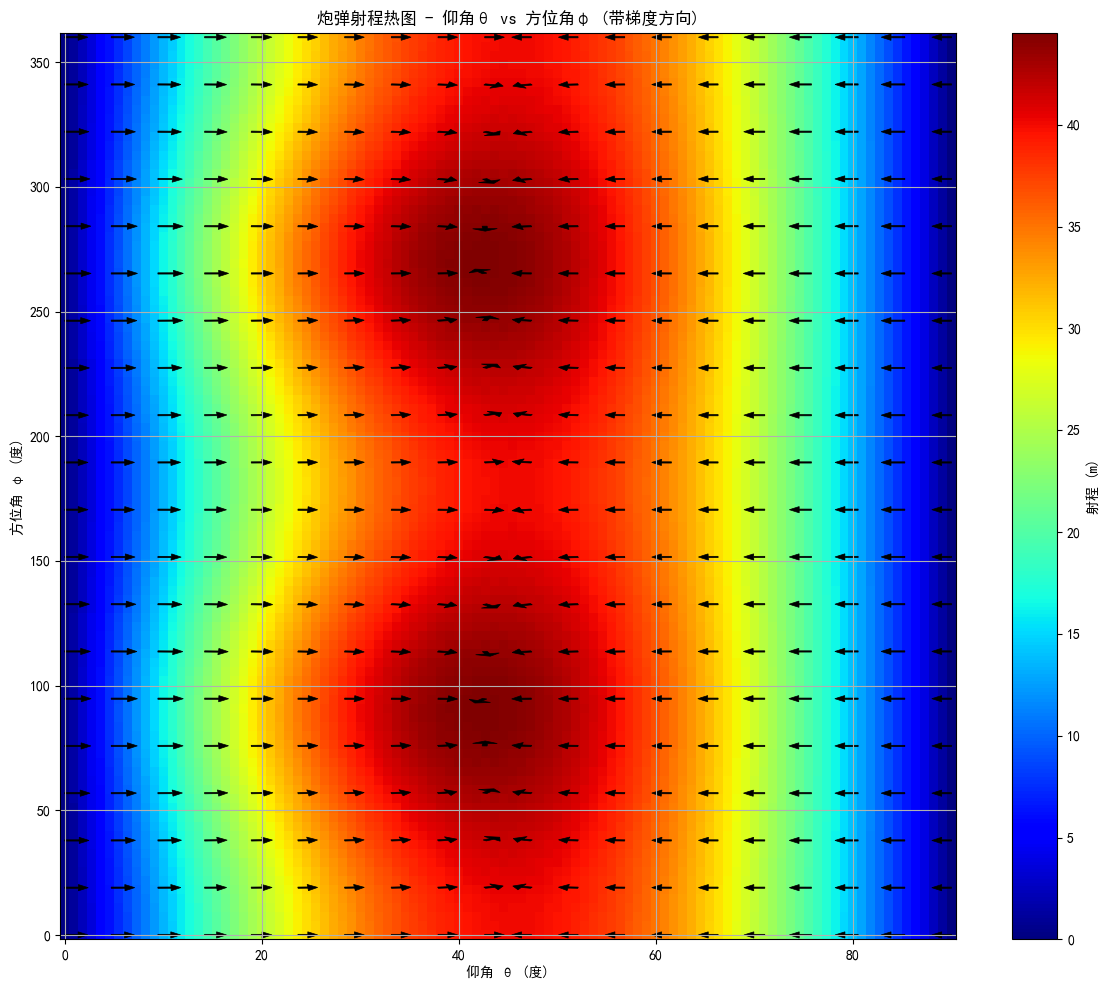

In [178]:
# 绘制带有梯度的热图
fig, ax, theta_vals, phi_vals, distances = (
    plot_projection_distance_heat_map_with_gradient(
        speed=20,
        resolution=100,
        gradient_density=20,  # 梯度箭头的密度
        gradient_scale=1,  # 调整箭头长度的缩放因子
        elevation=ridge,
    )
)

In [193]:
from py_lib.vectors import length

def gradient_ascent(f, xstart, ystart, tolerance=1e-6):
    x = xstart
    y = ystart
    grad = approx_gradient(f, x, y)
    while length(grad) > tolerance:
        x += grad[0]
        y += grad[1]
        grad = approx_gradient(f, x, y)
    return x, y


def gradient_ascent_points(f, xstart, ystart, rate=1, tolerance=1e-6):
    x = xstart
    y = ystart
    xs, ys = [x], [y]
    grad = approx_gradient(f, x, y)
    while length(grad) > tolerance:
        x += rate * grad[0]
        y += rate * grad[1]
        grad = approx_gradient(f, x, y)
        xs.append(x)
        ys.append(y)
    return xs, ys

In [201]:
gradient_ascent(landing_distance, 10, 20)

(np.float64(42.452993059638075), np.float64(89.99968488313057))

最大射程: 44.52 m
最优仰角(θ): 42.73°
最优方位角(φ): 90.91°


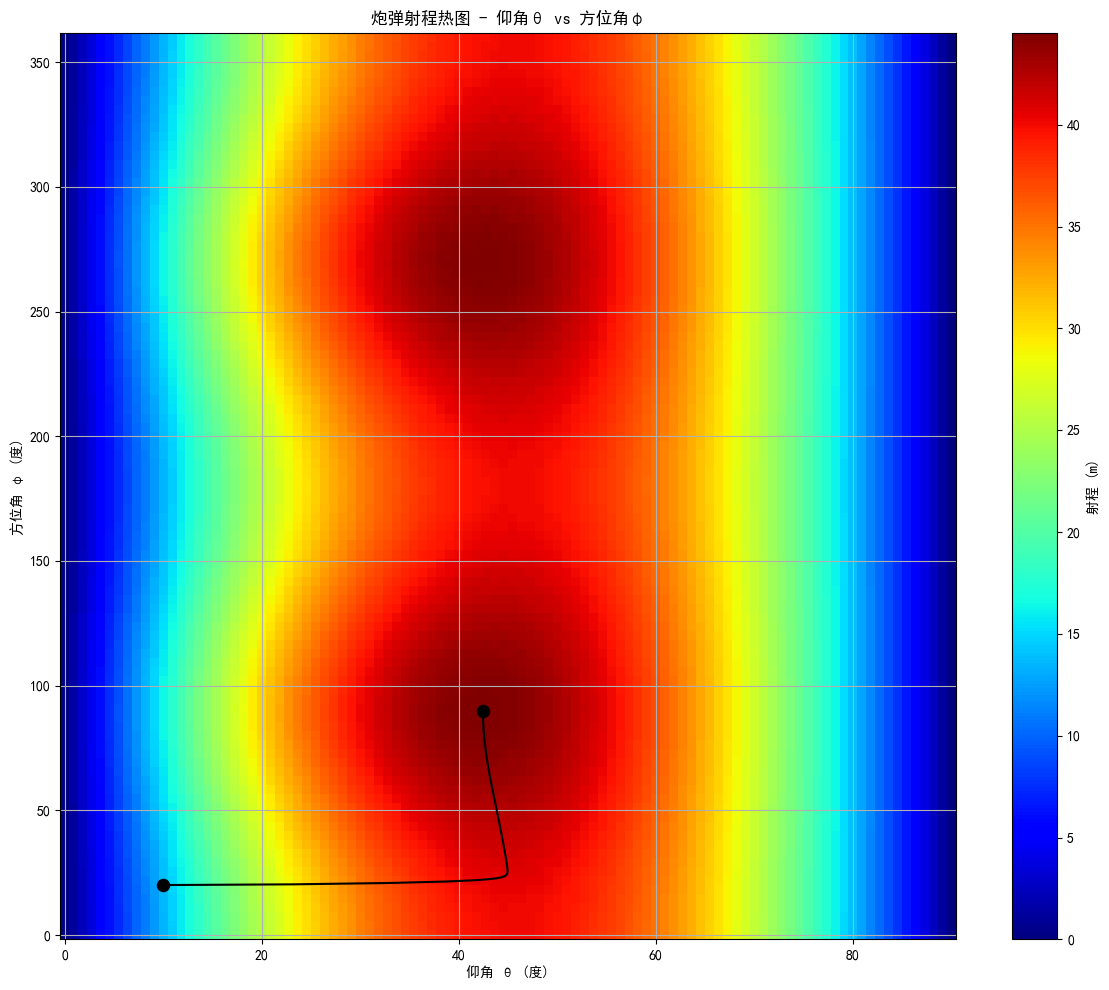

In [204]:
# 首先获取基础热图
fig, ax, theta_values, phi_values, distances = plot_projection_distance_heat_map(
    speed=20,
    resolution=100,
    elevation=ridge,
    show_plot=False,  # 不立即显示
    show_max_point=False,  # 不显示最大点
)
plt.scatter([10, 42.452993059638075], [20, 89.99968488313057], c="k", s=75)
plt.plot(*gradient_ascent_points(landing_distance, 10, 20, rate=10), c="k")